# Project data onto PBMC68K
## Xiaonan Wang
## 07Aug2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import anndata

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.5.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


# Quick process PBMC 68K dataset

In [2]:
PBMC_data = sc.read('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Fernando/Autolus_paper/TenX_68K_data/filtered_matrices_mex/hg19/matrix.mtx', cache=True).T
PBMC_data.obs_names = np.genfromtxt('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Fernando/Autolus_paper/TenX_68K_data/filtered_matrices_mex/hg19/barcodes.tsv',delimiter='\t', dtype=str)
PBMC_data.var = pd.read_csv('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Fernando/Autolus_paper/TenX_68K_data/filtered_matrices_mex/hg19/genes.tsv', names=['Ensembl Name', 'Gene Name'], sep='\t', header=None)
PBMC_data.var_names = PBMC_data.var['Gene Name']
PBMC_data.obs['Cell Type'] = np.genfromtxt('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Fernando/Autolus_paper/TenX_68K_data/filtered_matrices_mex/hg19/PBMC68k.cellLables.txt', delimiter='\t', dtype=str)
PBMC_data.var_names_make_unique()

... reading from cache file cache/home-xw251-rds-rds-bg200-hphi-gottgens-users-xw251-Lab_Members-Fernando-Autolus_paper-TenX_68K_data-filtered_matrices_mex-hg19-matrix.h5ad


In [3]:
PBMC_data.obs.head(3)

,Cell Type
AAACATACACCCAA-1,CD8+ Cytotoxic T
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic
AAACATACCGGAGA-1,CD4+/CD25 T Reg


In [4]:
PBMC_data.var['mt'] = PBMC_data.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(PBMC_data, qc_vars=['mt'], inplace=True)

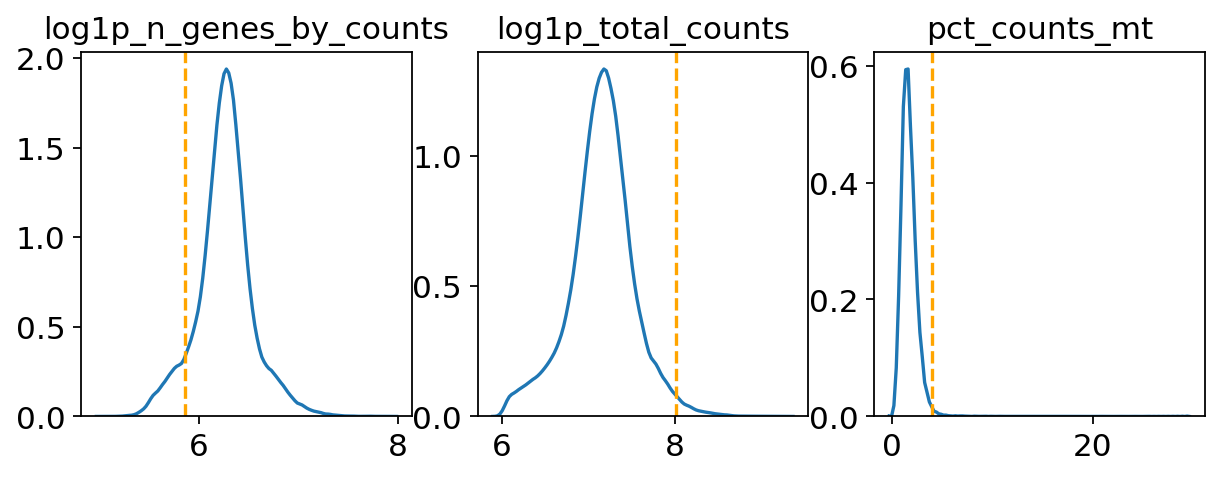

In [5]:
import seaborn as sns
fig,ax = plt.subplots(1,3, figsize=(9,3))
sns.kdeplot(PBMC_data.obs['log1p_n_genes_by_counts'], ax=ax[0])
ax[0].grid(False)
ax[0].get_legend().remove()
ax[0].set_title('log1p_n_genes_by_counts')
ax[0].axvline(np.log1p(350), c='orange', linestyle='--')
sns.kdeplot(PBMC_data.obs['log1p_total_counts'], ax=ax[1])
ax[1].grid(False)
ax[1].get_legend().remove()
ax[1].set_title('log1p_total_counts')
ax[1].axvline(np.log1p(3000), c='orange', linestyle='--')
sns.kdeplot(PBMC_data.obs['pct_counts_mt'], ax=ax[2])
ax[2].grid(False)
ax[2].get_legend().remove()
ax[2].set_title('pct_counts_mt')
ax[2].axvline(4, c='orange', linestyle='--')

In [6]:
# filter cells and genes here based on user preference
sc.pp.filter_cells(PBMC_data, min_genes=350)
sc.pp.filter_genes(PBMC_data, min_cells=1)
# further QC with high mit percentage and n_counts
PBMC_data = PBMC_data[(PBMC_data.obs['pct_counts_mt'] < 4) & (PBMC_data.obs['total_counts'] <= 3000), :].copy()
sc.pp.normalize_per_cell(PBMC_data, counts_per_cell_after=1e4) 
sc.pp.log1p(PBMC_data)
PBMC_data.raw = PBMC_data

filtered out 5672 cells that have less than 350 genes expressed
filtered out 12464 genes that are detected in less than 1 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [7]:
sc.pp.highly_variable_genes(
    PBMC_data, min_mean=0.02, max_mean=3, min_disp=0.5, inplace=True)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


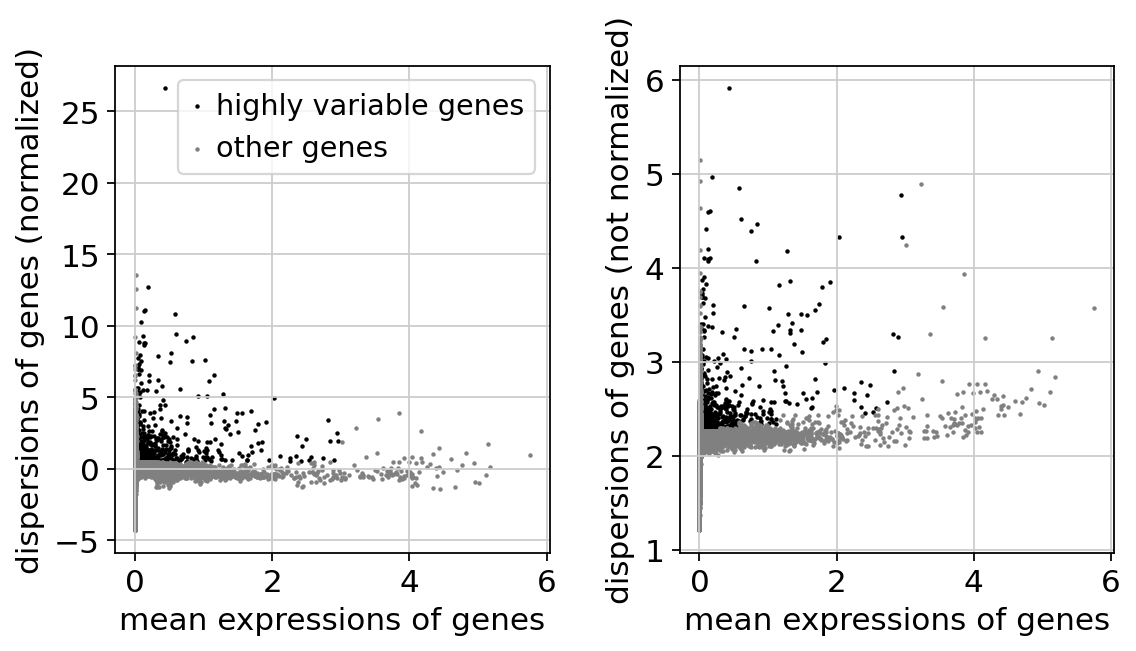

In [8]:
sc.pl.highly_variable_genes(PBMC_data)

In [9]:
print(np.sum(PBMC_data.var.highly_variable))

1471


In [10]:
PBMC_data = PBMC_data[:, PBMC_data.var.highly_variable]

In [11]:
PBMC_data.shape

(61326, 1471)

In [12]:
PBMC_data.write('./write/PBMC_68K_lognorm.h5ad')

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Cell Type' as categorical


# Projection

In [13]:
PBMC_data = sc.read('./write/PBMC_68K_lognorm.h5ad')

In [14]:
PBMC_hvg = PBMC_data.var_names
print(len(PBMC_hvg))

1471


In [15]:
PBMC_data = anndata.AnnData(X=np.exp(PBMC_data.raw.X.todense())-1, obs=PBMC_data.obs, var=PBMC_data.raw.var, obsm=PBMC_data.obsm)

In [16]:
adata = sc.read('./write/PBMC_processed.h5ad')

In [17]:
# match it to niki data, norm without log
adata = anndata.AnnData(X=np.exp(adata.raw.X.todense())-1, obs=adata.obs, var=adata.raw.var, obsm=adata.obsm)

In [18]:
OLG = np.intersect1d(PBMC_hvg, adata.var_names)
print(len(OLG))
adata = adata[:,OLG].copy()
PBMC_data = PBMC_data[:,OLG].copy()

sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
sc.pp.normalize_per_cell(PBMC_data, counts_per_cell_after=10000)

sc.pp.log1p(adata)
sc.pp.log1p(PBMC_data)

1466
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [19]:
print(adata.shape)
print(PBMC_data.shape)

(15293, 1466)
(61326, 1466)


In [20]:
# scale them together
data_comb = adata.concatenate(PBMC_data)
sc.pp.scale(data_comb)

In [21]:
adata = anndata.AnnData(X=data_comb[data_comb.obs['batch'] == '0',:].X, obs=adata.obs, var=adata.var, obsm=adata.obsm, uns=adata.uns)
PBMC_data = anndata.AnnData(X=data_comb[data_comb.obs['batch'] == '1',:].X, obs=PBMC_data.obs, var=PBMC_data.var, obsm=PBMC_data.obsm, uns=PBMC_data.uns)

In [22]:
print(adata.shape)
print(PBMC_data.shape)

(15293, 1466)
(61326, 1466)


In [23]:
from sklearn.decomposition import PCA
pca_ = PCA(n_components=50, svd_solver='auto', random_state=0)

In [24]:
pca_.fit(PBMC_data.X)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [25]:
X_pca1 = pca_.transform(PBMC_data.X)
X_pca2 = pca_.transform(adata.X)

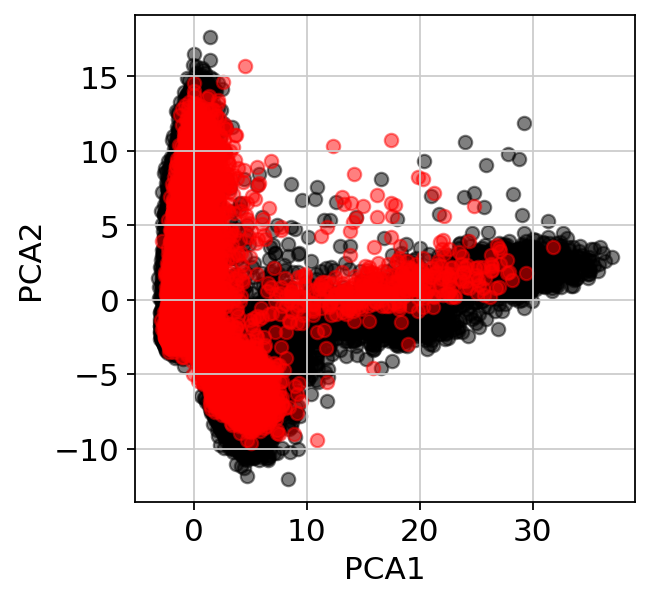

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_pca1[:,0], X_pca1[:,1], c='black', alpha=0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
ax1.scatter(X_pca2[:,0], X_pca2[:,1], c='red', alpha=0.5)
plt.show()

In [27]:
from sklearn.metrics.pairwise import euclidean_distances
D_sub = euclidean_distances(X_pca2, X_pca1)

In [28]:
print(X_pca1.shape)
print(X_pca2.shape)
print(D_sub.shape)

(61326, 50)
(15293, 50)
(15293, 61326)


In [29]:
from collections import Counter
from collections import defaultdict
cl_assigned = []
Rstore = defaultdict(list) # dictionary to store results
for i in range(D_sub.shape[0]):
    CellDis = D_sub[i,:]
    CellDis_sorted = np.argsort(CellDis)[:15]
    max_samples = PBMC_data.obs_names[CellDis_sorted]
    cl_assigned.append(max_samples)
    Rstore['MinDist'].append(np.min(CellDis[CellDis_sorted]))
    Rstore['MedianDist'].append(np.median(CellDis[CellDis_sorted]))
    Rstore['MaxDist'].append(np.max(CellDis[CellDis_sorted]))
    Rstore['SD'].append(np.std(CellDis[CellDis_sorted]))
    Rstore['PBMC_CT'].append(Counter(PBMC_data.obs['Cell Type'][CellDis_sorted]).most_common(1)[0][0])
Rstore = pd.DataFrame.from_dict(Rstore)
Rstore.index = adata.obs_names

In [30]:
Rstore.head(3)

,MinDist,MedianDist,MaxDist,SD,PBMC_CT
AAACCTGAGCAAATCA-1-0,3.103259,3.527457,3.597236,0.140980,CD8+/CD45RA+ Naive Cytotoxic
AAACCTGAGGTTACCT-1-0,5.770245,6.692144,6.806241,0.314530,CD4+/CD45RA+/CD25- Naive T
AAACCTGCAAAGTGCG-1-0,7.298321,8.996329,9.353425,0.530901,CD14+ Monocyte


In [31]:
Rstore.to_csv('Proj_PBMC_onto_PBMC68K_results.csv')